In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from sklearn.pipeline import Pipeline


In [43]:
## read in the dataset
df = pd.read_csv('../data/2023/model_data/matchup_features.csv')

In [44]:
df.columns

Index(['Season', 'TeamID_1', 'TeamID_2', 'Seed_1', 'Seed_2', 't1_score_diff',
       'diff_total_games', 'diff_win_pct', 'diff_avg_points_for',
       'diff_avg_points_against', 'diff_avg_game_margin',
       'diff_std_game_margin', 'diff_non_home_wins', 'diff_home_losses',
       'diff_close_wins', 'diff_close_losses', 'diff_3FGA_pg', 'diff_3_pct',
       'diff_FTA_pg', 'diff_FT_pct', 'diff_TOV_pg', 'diff_avg_pace',
       'diff_off_eff', 'diff_def_eff', 'diff_pythag_win_pct', 'diff_luck',
       'diff_wins_vs_tourney_teams', 'diff_away_wins_vs_tourney_teams',
       'diff_losses_vs_tourney_teams', 'diff_losses_vs_non_tourney_teams',
       'diff_games_vs_tourney_teams', 'diff_final_net', 'diff_net_improvement',
       'diff_final_pom', 'diff_pom_improvement', 'diff_pi_i',
       'diff_coach_WL_car', 'diff_tourneys_car', 'diff_sw16_car',
       'diff_ff_car', 'diff_champ_car', 'diff_returning_min_pct',
       'diff_returning_score_pct', 'diff_preseason_pts'],
      dtype='object')

In [93]:
## read in the dataset
df = pd.read_csv('data/2023/model_data/matchup_features.csv')
X = df[[x for x in df.columns if x not in ['t1_score_diff','Season','TeamID_1','TeamID_2','Seed_1','Seed_2']]]
y_diff = df['t1_score_diff']
y = y_diff.map(lambda x: int(x>0))
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
# y_train_dif = y_train
# y_test_dif = y_test
# y_train_win = y_train.map(lambda x: int(x > 0))
# y_test_win = y_test.map(lambda x: int(x > 0))

# 1) Win classifier

## 1a) Picking a model

In [47]:
# logistic regression w recursive feature elimination and then hyperparameter tuning

min_features_to_select =1

lr_clf = LogisticRegression()

lr_rfecv = RFECV(estimator=lr_clf,step=1,cv=StratifiedKFold(2),scoring='accuracy',
             min_features_to_select=min_features_to_select)

lr_rfecv.fit(X_train, y_train_win)
print("Optimal number of features : %d" % lr_rfecv.n_features_)



Optimal number of features : 8


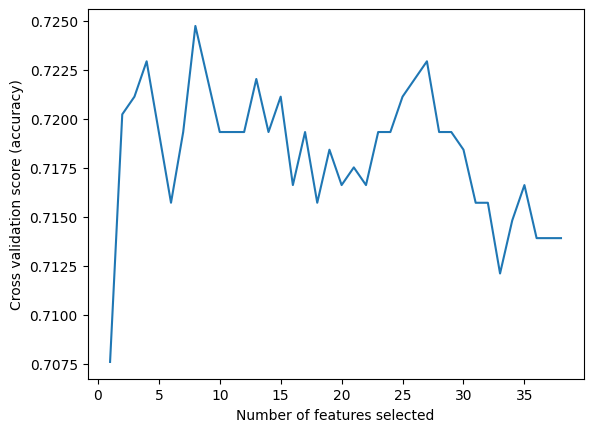

In [48]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(lr_rfecv.cv_results_['mean_test_score']) + min_features_to_select),
    lr_rfecv.cv_results_['mean_test_score']
)
plt.show()

# scores = cross_val_score(lr_clf, X_train, y_train_win, scoring="accuracy", cv=5)
# print('Mean: ',scores.mean())
# print('Std: ',scores.std())

In [49]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(lr_rfecv.support_)))

lr_clf = LogisticRegression(max_iter = 100,tol=0.0001)
lr_clf.fit(X_train[selected_features], y_train_win)
print(lr_clf.score(X_train[selected_features],y_train_win))
print(selected_features)

0.7247292418772563
['diff_def_eff' 'diff_luck' 'diff_losses_vs_tourney_teams'
 'diff_losses_vs_non_tourney_teams' 'diff_final_pom' 'diff_pi_i'
 'diff_tourneys_car' 'diff_sw16_car']


In [50]:
lr_clf.coef_

array([[-0.15774496,  0.21123563,  0.16035241,  0.07595096, -0.72916915,
         0.76911613, -0.81442986,  1.08543854]])

Optimal number of features : 7


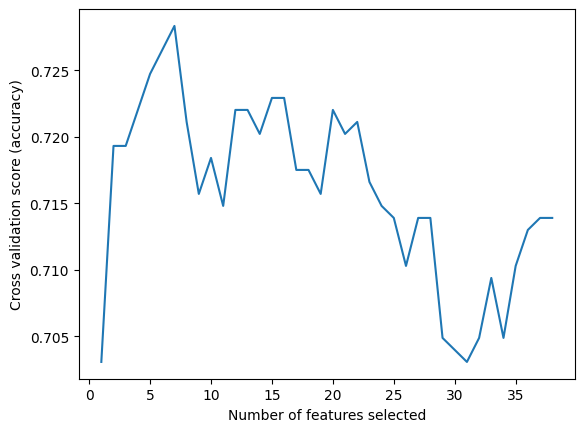

In [51]:
# support vector classifier w recursive feature elimination adn then hyperparameter tuning
svc_clf = SVC(kernel='linear')
svc_rfecv = RFECV(estimator=svc_clf,step=1,cv=StratifiedKFold(2),scoring='accuracy',
             min_features_to_select=min_features_to_select)

svc_rfecv.fit(X_train, y_train_win)
print("Optimal number of features : %d" % svc_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(svc_rfecv.cv_results_['mean_test_score']) + min_features_to_select),
    svc_rfecv.cv_results_['mean_test_score'],
)
plt.show()

# scores = cross_val_score(svc_clf, X_train, y_win, scoring="accuracy", cv=10)
# print('Mean: ',scores.mean())
# print('Std: ',scores.std())

In [52]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(svc_rfecv.support_)))

svc_clf.fit(X_train[selected_features], y_train_win)
print(svc_clf.score(X_train[selected_features],y_train_win))
print(selected_features)

0.7220216606498195
['diff_win_pct' 'diff_losses_vs_tourney_teams'
 'diff_losses_vs_non_tourney_teams' 'diff_final_pom' 'diff_pi_i'
 'diff_tourneys_car' 'diff_sw16_car']


Optimal number of features : 5


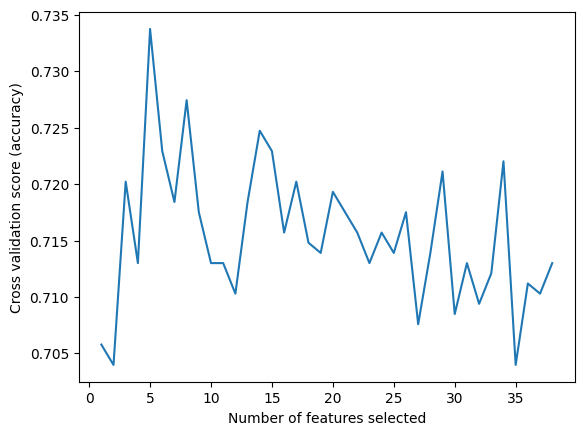

In [53]:
# random forest classifier
forest_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,    
)

forest_rfecv = RFECV(estimator=forest_clf,step=1,cv=StratifiedKFold(2),scoring='accuracy',
             min_features_to_select=min_features_to_select)

forest_rfecv.fit(X_train, y_train_win)
print("Optimal number of features : %d" % forest_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(forest_rfecv.cv_results_['mean_test_score']) + min_features_to_select),
    forest_rfecv.cv_results_['mean_test_score'],
)
plt.show()

# scores = cross_val_score(forest_clf, X_train, y_win, scoring="accuracy", cv=10)
# print('Mean: ',scores.mean())
# print('Std: ',scores.std())

In [54]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(forest_rfecv.support_)))

forest_clf.fit(X_train[selected_features], y_train_win)
print(forest_clf.score(X_train[selected_features],y_train_win))


0.7906137184115524


In [55]:
# xgboost classifier
xgb_clf = XGBClassifier(
    n_estimators=1000,
#     use_label_encoder=False,
    max_depth= 4,
    min_child_weight = 1,
    gamma = 0,
    verbosity=0,
    colsample_bytree = 0.5,
    subsample = 0.5
)

xgb_rfecv = RFECV(estimator=xgb_clf,step=1,cv=StratifiedKFold(5),scoring='accuracy',
             min_features_to_select=min_features_to_select)

xgb_rfecv.fit(X_train, y_train_win)
print("Optimal number of features : %d" % xgb_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(xgb_rfecv.cv_results_['mean_test_score']) + min_features_to_select),
    xgb_rfecv.cv_results_['mean_test_score'],
)
plt.show()


# scores = cross_val_score(xgb_clf, X_train, y_win, scoring="accuracy", cv=10, fit_params={'eval_metric':'logloss'})
# print('Mean: ',scores.mean())
# print('Std: ',scores.std())




KeyboardInterrupt: 

In [ ]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(xgb_rfecv.support_)))

xgb_clf.fit(X_train[selected_features], y_train_win)
print(xgb_clf.score(X_train[selected_features],y_train_win))
print(selected_features)

## 1b) Fine Tuning

In [428]:
features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(lr_rfecv.support_)))

In [446]:
features

array(['diff_final_pom', 'diff_pi_i', 'diff_tourneys_car',
       'diff_sw16_car', 'diff_returning_min_pct',
       'diff_returning_score_pct'], dtype=object)

In [449]:
features = np.array(['diff_final_pom','diff_pi_i','diff_tourneys_car','diff_sw16_car','diff_returning_score_pct'])

In [450]:
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    verbosity=0
)

In [133]:
from hyperopt import fmin, tpe, hp, anneal, Trials
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.impute import SimpleImputer

In [135]:
## read in the dataset
df = pd.read_csv('data/2023/model_data/matchup_features.csv')
# X = df[[x for x in df.columns if x not in ['t1_score_diff','Season','TeamID_1','TeamID_2','Seed_1','Seed_2']]]
X = df[[x for x in df.columns if x != 't1_score_diff']]
y = df['t1_score_diff'].map(lambda x: int(x>0))
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

numerics = [x for x in df.columns if x not in ['t1_score_diff','Season','TeamID_1','TeamID_2','Seed_1','Seed_2']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    [("numerics",numeric_transformer,numerics)]
)


In [136]:
def gb_mse_cv(params, random_state=42):
    
    
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_child_weight': params['min_child_weight'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'gamma': params['gamma'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha']             
             }
    


    model = XGBClassifier(random_state=random_state,verbosity=0, **params)    
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(3), scoring="accuracy").mean()

    return score

In [137]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 64, 128, 1),
       'max_depth' : hp.quniform('max_depth', 1, 1000, 1),
       'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
       'subsample': hp.uniform('subsample',0.5,1),
       'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
       'eta': hp.loguniform('eta', -5, -1),
       'gamma': hp.uniform('gamma', 0,20),
       'reg_lambda': hp.loguniform('reg_lambda',0,7),
       'reg_alpha': hp.uniform('reg_alpha',0,100)       
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

print(best)
# # computing the score on the training set
# model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
#                       max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
# model.fit(train_data,train_targets)
# sa_test_score=mean_squared_error(test_targets, model.predict(test_data))

# print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

100%|████████████████████████████████| 100/100 [01:03<00:00,  1.57trial/s, best loss: -0.7275056446821152]
{'colsample_bytree': 0.5605844174042656, 'eta': 0.25828278334141047, 'gamma': 18.057314671177963, 'max_depth': 724.0, 'min_child_weight': 9.0, 'n_estimators': 76.0, 'reg_alpha': 0.20229053633027005, 'reg_lambda': 1.3089165619058296, 'subsample': 0.5934878518120013}


In [138]:
xgb_clf = XGBClassifier(
    verbosity=0,
    colsample_bytree= best['colsample_bytree'],
    eta = best['eta'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    n_estimators = int(best['n_estimators']),
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    subsample = best['subsample'] 
)

In [139]:
pipe = Pipeline([('preprocessor', preprocessor), ('model', xgb_clf)])

In [140]:
pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.7284060552092609
0.704


In [141]:
joblib.dump(pipe, 'models/2023/xgb_pipeline_vf.joblib')

['models/2023/xgb_pipeline_vf.joblib']

In [130]:
feature_importance_df = pd.DataFrame(zip(X_train.columns,pipe['model'].feature_importances_),columns=['Feature','Importance'])

In [131]:
feature_importance_df.sort_values(by='Importance',inplace=True,ascending=False)

In [132]:
feature_importance_df

,Feature,Importance
27,diff_losses_vs_tourney_teams,0.267787
32,diff_final_pom,0.215676
25,diff_wins_vs_tourney_teams,0.150513
30,diff_final_net,0.106695
29,diff_games_vs_tourney_teams,0.105793
21,diff_off_eff,0.085626
37,diff_sw16_car,0.067910
31,diff_net_improvement,0.000000
33,diff_pom_improvement,0.000000
1,TeamID_1,0.000000


# 2) Score differential predictor

## 2a) Picking a model

Optimal number of features : 8


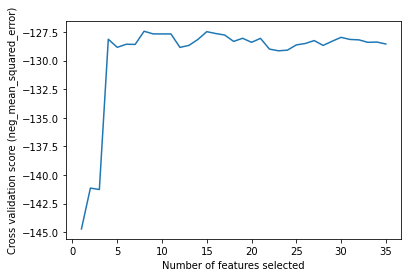

In [339]:
# linear regression
lin_reg = LinearRegression()
lin_rfecv = RFECV(estimator=lin_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

lin_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % lin_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(lin_rfecv.grid_scores_) + min_features_to_select),
    lin_rfecv.grid_scores_,
)
plt.show()

# scores = cross_val_score(lin_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [354]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(lin_rfecv.support_)))

lin_reg = LinearRegression()
lin_reg.fit(X_train[selected_features], y_train_dif)
print(lin_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,lin_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.42335638882565674
11.010604028646712
['diff_avg_points_for' 'diff_avg_points_against' 'diff_avg_game_margin'
 'diff_pythag_win_pct' 'diff_final_pom' 'diff_pi_i' 'diff_tourneys_car'
 'diff_sw16_car']


In [343]:
lin_reg.coef_

array([-4.28003549,  3.10428375,  5.78067235, -2.35445505, -5.81775989,
        3.09784647, -2.56496173,  3.99163977])

Optimal number of features : 8


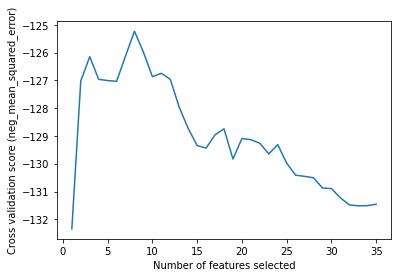

In [347]:
# support vector machine
svr_reg = SVR(kernel='linear')

svr_rfecv = RFECV(estimator=svr_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

svr_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % svr_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(svr_rfecv.grid_scores_) + min_features_to_select),
    svr_rfecv.grid_scores_,
)
plt.show()

# scores = cross_val_score(svr_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [355]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(svr_rfecv.support_)))

svr_reg = SVR(kernel='linear')
svr_reg.fit(X_train[selected_features], y_train_dif)
print(svr_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,svr_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.4236488031222455
11.007811952013084
['diff_avg_game_margin' 'diff_pythag_win_pct' 'diff_final_net'
 'diff_final_pom' 'diff_pi_i' 'diff_coach_WL_car' 'diff_tourneys_car'
 'diff_sw16_car']


Optimal number of features : 25


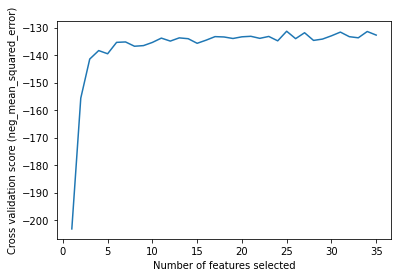

In [358]:
# random forest
forest_reg = RandomForestRegressor()
forest_rfecv = RFECV(estimator=forest_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

forest_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % forest_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(forest_rfecv.grid_scores_) + min_features_to_select),
    forest_rfecv.grid_scores_,
)
plt.show()
# scores = cross_val_score(forest_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [362]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(forest_rfecv.support_)))

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train[selected_features], y_train_dif)
print(forest_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,forest_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.9090238011083311
4.373421099730032
['diff_win_pct' 'diff_avg_points_for' 'diff_avg_points_against'
 'diff_avg_game_margin' 'diff_std_game_margin' 'diff_close_wins'
 'diff_3FGA_pg' 'diff_3_pct' 'diff_FTA_pg' 'diff_FT_pct' 'diff_TOV_pg'
 'diff_avg_pace' 'diff_off_eff' 'diff_def_eff' 'diff_pythag_win_pct'
 'diff_luck' 'diff_games_vs_tourney_teams' 'diff_final_net'
 'diff_net_improvement' 'diff_final_pom' 'diff_pom_improvement'
 'diff_pi_i' 'diff_coach_WL_car' 'diff_tourneys_car' 'diff_sw16_car']


Optimal number of features : 23


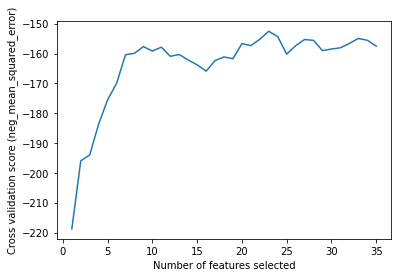

In [361]:
# xgboost
xgb_reg = XGBRegressor()
xgb_rfecv = RFECV(estimator=xgb_reg,step=1,cv=2,scoring='neg_mean_squared_error',
             min_features_to_select=min_features_to_select)

xgb_rfecv.fit(X_train, y_train_dif)
print("Optimal number of features : %d" % xgb_rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(
    range(min_features_to_select, len(xgb_rfecv.grid_scores_) + min_features_to_select),
    xgb_rfecv.grid_scores_,
)
plt.show()
# scores = cross_val_score(forest_reg, X, y_dif, scoring="neg_mean_squared_error", cv=5)
# rmse_scores = np.sqrt(-scores)
# print('Mean: ',rmse_scores.mean())
# print('Std: ',rmse_scores.std())

In [363]:
selected_features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(xgb_rfecv.support_)))

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train[selected_features], y_train_dif)
print(xgb_reg.score(X_train[selected_features],y_train_dif))
print(mean_squared_error(y_train_dif,xgb_reg.predict(X_train[selected_features]))**0.5)
print(selected_features)

0.9987993102498075
0.502426807735927
['diff_FTA_pg' 'diff_FT_pct' 'diff_TOV_pg' 'diff_avg_pace' 'diff_off_eff'
 'diff_def_eff' 'diff_pythag_win_pct' 'diff_luck'
 'diff_wins_vs_tourney_teams' 'diff_away_wins_vs_tourney_teams'
 'diff_losses_vs_tourney_teams' 'diff_losses_vs_non_tourney_teams'
 'diff_games_vs_tourney_teams' 'diff_final_net' 'diff_net_improvement'
 'diff_final_pom' 'diff_pom_improvement' 'diff_pi_i' 'diff_coach_WL_car'
 'diff_tourneys_car' 'diff_sw16_car' 'diff_ff_car' 'diff_champ_car']


In [92]:
from matplotlib.pyplot import figure



<BarContainer object of 23 artists>

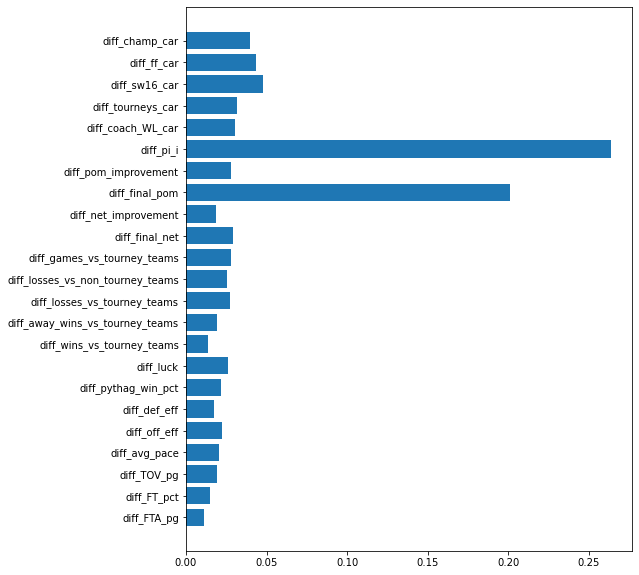

In [366]:
figure(figsize=(8, 10))
plt.barh(selected_features, xgb_reg.feature_importances_)

## 2b) Fine tuning

In [367]:
features = np.ma.compressed(np.ma.masked_array(X.columns,np.invert(lin_rfecv.support_)))

In [443]:
features

array(['diff_final_pom', 'diff_pi_i', 'diff_tourneys_car',
       'diff_sw16_car', 'diff_returning_min_pct',
       'diff_returning_score_pct'], dtype=object)

In [ ]:
xgb_clf

In [334]:
from hyperopt import fmin, tpe, hp, anneal, Trials

In [373]:
def gb_mse_cv(params, random_state=42, cv=2, X=X_train[features], y=y_train_dif):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']),
              'min_child_weight': params['min_child_weight'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'gamma': params['gamma'],
              'reg_lambda': params['reg_lambda'],
              'reg_alpha': params['reg_alpha']             
             }
    
    # we use this params to create a new LGBM Regressor
    model = XGBRegressor(random_state=random_state, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error").mean()

    return score

In [374]:
random_state=42

# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
       'max_depth' : hp.quniform('max_depth', 2, 15, 1),
       'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),
       'subsample': hp.uniform('subsample',0.5,1),
       'colsample_bytree': hp.uniform('colsample_bytree',0.5,1),
       'eta': hp.loguniform('eta', -5, -1),
       'gamma': hp.uniform('gamma', 0,20),
       'reg_lambda': hp.loguniform('reg_lambda',0,7),
       'reg_alpha': hp.uniform('reg_alpha',0,100)       
      }

# trials will contain logging information
trials = Trials()

best=fmin(fn=gb_mse_cv, # function to optimize
          space=space, 
          algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals=100, # maximum number of iterations
          trials=trials, # logging
          rstate=np.random.default_rng(42) # fixing random state for the reproducibility
         )

print(best)
# # computing the score on the training set
# model = LGBMRegressor(random_state=random_state, n_estimators=int(best['n_estimators']),
#                       max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
# model.fit(train_data,train_targets)
# sa_test_score=mean_squared_error(test_targets, model.predict(test_data))

# print("Best MSE {:.3f} params {}".format( gb_mse_cv(best), best))

100%|██████████| 100/100 [03:20<00:00,  2.00s/trial, best loss: 127.37956349673848]
{'colsample_bytree': 0.6087692944626087, 'eta': 0.009590545956371677, 'gamma': 13.089787354669978, 'max_depth': 2.0, 'min_child_weight': 16.0, 'n_estimators': 1206.0, 'reg_alpha': 94.95574656425667, 'reg_lambda': 8.074716967351131, 'subsample': 0.7920757818969743}


In [375]:
xgb_reg = XGBRegressor(
    colsample_bytree= best['colsample_bytree'],
    eta = best['eta'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    n_estimators = int(best['n_estimators']),
    reg_alpha = best['reg_alpha'],
    reg_lambda = best['reg_lambda'],
    subsample = best['subsample'] 
)

In [378]:
xgb_reg.fit(X_train[features], y_train_dif)
print(xgb_reg.score(X_train[features],y_train_dif))
print(mean_squared_error(y_train_dif,xgb_reg.predict(X_train[features]))**0.5)
print(features)

0.4756493569823418
10.499492426337998
['diff_avg_points_for' 'diff_avg_points_against' 'diff_avg_game_margin'
 'diff_pythag_win_pct' 'diff_final_pom' 'diff_pi_i' 'diff_tourneys_car'
 'diff_sw16_car']
